# Dynamic Bayesian Optimization: 
- Sina Dabiri 


In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
# plt.style.use('dark_background')
import GPy

In [2]:
path = "Mark_4sec_CA3PSD_ISO_freqamp_020619.csv"

In [11]:
class state_dr_gp:
    '''
    A class to run a Gaussian Process model. 
    
    
    '''
    def gp_model(self, csv_path):
        # Import datasets as pandas
        CA1_df = pd.read_csv(path)

        # Get frequency and amplitudes
        U1 = CA1_df.iloc[:,  0:2]
        # Get the coordinate of pre stimulation gamma 
        X0_coords = np.arange(33,52)

        # sum of pre stimulation gamma
        data = np.sum(CA1_df.iloc[:, X0_coords], axis=1)
        X0_psd = pd.DataFrame(data=data, columns=['sum_preStim_gamma'])
        X0_psd = X0_psd*1e10 # Need values >0 for GP model
        N_trials = np.size(X0_psd, axis=0)
        lower_bound = np.min(U1, axis=0)
        upper_bound = np.max(U1, axis=0)
        # sum of post stimulation gamma         
        X1_coords = np.arange(133,152)
        X1 = np.sum(CA1_df.iloc[:, X1_coords],axis=1)
        X1 = np.array(X1)
        X1 =X1[:, np.newaxis] # reshape
        X1 = X1*1e10 # bring to >0 range        
       
        return X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials;
    
    # initialize_data_dr_sim() function
    def initialize_data_dr_sim(self, U1, X0_psd, X1, kernel, slice_dim, ylabel):
       
        # input_data
        U1_X0 = U1.join(X0_psd)
        
        # create simple GP model
        m = GPy.models.GPRegression(U1_X0,X1,kernel)
        figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(1),legend=False, xlabel='Stim. Freq.', ylabel='Stim. Amp.',
                      title="before Optimization");
        display(canvas);
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax);
        
        # optimize and plot
        m.optimize(messages=True,max_f_eval = 1000);
        canvas = m.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
        display(canvas)
        ax = plt.gca()
        PCM = ax.get_children()[0]
        plt.colorbar(PCM, ax=ax)
        
        # Plotting slices of the model at amplitudes of 0, 10, and 50
        slices = [0, 10, 50]
        figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

        for i, y in zip(range(3), slices):
            print((1,y));

            canvas = m.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                            xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

        display(canvas);
        
        # Min and Max of State
        
        # Number of trials
        
        
        return U1_X0, X1, m; 
    
    
    #Sample Function
    def sample(self,testX, m):

        posteriorTestY = np.empty((100))
        simY  = np.empty((100))
        simMse = np.empty((100))

        state_est = m.posterior_samples_f(testX, full_cov=True, size=1)[:,0,0]
        simY, simMse = m.predict(testX)

        # print("mean is: \n",simY[0],"\n\n Variance is: \n", simMse[0])
        # # posteriorTestY
        # print(np.shape(posteriorTestY),'\n',posteriorTestY[0:10])
        # print(np.shape(simY),'\n', np.shape(simMse))

        return state_est, simY, simMse;
    
    # Acquisition Function
    def acquisition_function(self, simY, simMse, nu, t):
        # Upper Confidence Bound implementation
        #  if d=2 and delta=2
        tau_t = 2*np.log(t**2*(np.pi)**2/6)
        
        ucb = simY+(np.sqrt(nu*tau_t))*simMse
        
        return ucb
    
    # The next step training and bayes_opt_update_state() function
    def bayes_opt_update_state(self, U1, X1, ker_BaO):
         # create simple GP model
        trained_model_BaO = GPy.models.GPRegression(U1,X1,ker_BaO)
        trained_model_BaO.optimize(messages=True,max_f_eval = 1000);
        
        return trained_model_BaO
    
    
    def transition_state(self, U1, X0_psd, state_est, testX):
        state_data_dr = X0_psd
        current_state = np.append(X0_psd, state_est[:,0:1], axis=0)
#         testX_shape_row, testX_shape_col = np.shape(testX)
        
#         current_state = np.empty(())
        
        return current_state
        
    

In [12]:
model = state_dr_gp()

In [13]:
# Get the input U1 and X0_psd, and the X1 outputs
X0_coords, U1, X1, lower_bound, upper_bound, X0_psd, N_trials = model.gp_model(path)

In [26]:
n_all_samples = np.shape(U1)[0]
n_burn_in = 20
n_samples= 150
n_acquisition = 50
print(n_all_samples)

384


In [40]:
hill_sum_preStim_gamma = np.empty((n_all_samples))
min_sum_preStim_gamma = np.min(X0_psd['sum_preStim_gamma'])
max_sum_preStim_gamma = np.max(X0_psd['sum_preStim_gamma'])
half_n_samples = int(n_all_samples/2)
step_size = (max_sum_preStim_gamma-min_sum_preStim_gamma)/half_n_samples
hill_sum_preStim_gamma[0:half_n_samples] = np.arange(min_sum_preStim_gamma, max_sum_preStim_gamma, step_size)
hill_sum_preStim_gamma[half_n_samples:n_all_samples] = np.arange(max_sum_preStim_gamma,min_sum_preStim_gamma, -step_size)
print("min preStimGamma is: \n", min_sum_preStim_gamma, " \n max preStimGamma is:", max_sum_preStim_gamma)
print(hill_sum_preStim_gamma[0:3], np.shape(hill_sum_preStim_gamma))

min preStimGamma is: 
 0.8137995193089469  
 max preStimGamma is: 10.999128829958241
[0.81379952 0.86684811 0.9198967 ] (384,)


In [29]:
hill_sum_preStim_gamma_pd = pd.DataFrame({'sum_preStim_gamma':hill_sum_preStim_gamma})
hill_sum_preStim_gamma_pd.head()

,sum_preStim_gamma
0,0.813800
1,0.866848
2,0.919897
3,0.972945
4,1.025994


In [24]:
print('freq and amplitude used are: \n', U1[0:4])

freq and amplitude used are: 
    Stim_1  Stim_2
0      17      30
1      42      40
2      35      30
3      23      50


In [15]:
U1.loc[0:10, 'Stim_1']

0     17
1     42
2     35
3     23
4     42
5     35
6     11
7      7
8     17
9     11
10    17
Name: Stim_1, dtype: int64

In [25]:
print(np.shape(U1), np.shape(hill_sum_preStim_gamma_pd))

(384, 2) (150, 1)


## 1.2 First BaO Model is trained on all of the dataset

In [30]:
ker_BaO = GPy.kern.Matern52(input_dim=3, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

In [31]:
slice_dim = 1
ylabel='Predicted Gamma'

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x2a25d3086d0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2a25d341cd0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s14  0001   5.393880e+03   2.147197e+06 
    03s42  0021   1.114771e+03   2.638966e+00 
    05s05  0033   1.113416e+03   3.521068e-07 
Runtime:     05s05
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x2a25cba57c0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2a25d024820>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x2a25d1bb430>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2a25d1a4550>]}

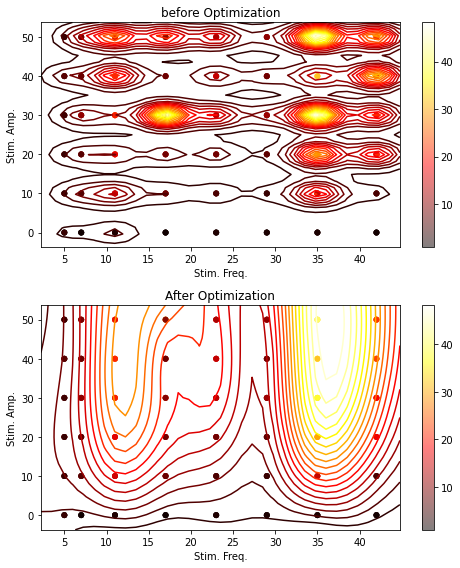

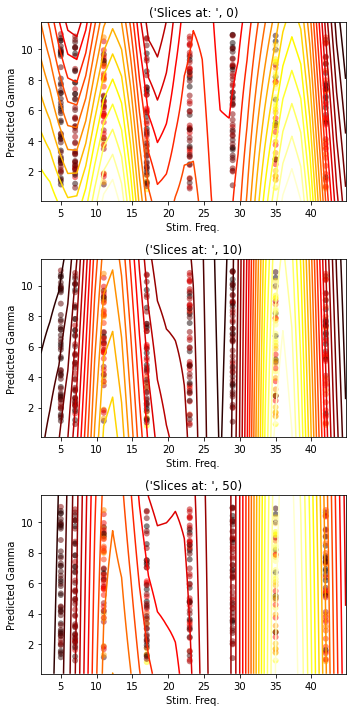

In [32]:
x_BaO, y_BaO, trained_model_BaO = model.initialize_data_dr_sim(U1, hill_sum_preStim_gamma_pd, X1, ker_BaO, slice_dim, ylabel)

## 1.3: Train the second model on just the burn-in points, and then use the Acquisition function to pick the next freq/amp/PreStimGamma 

- Then get the suggested freq/amp/preStimGamma from the first model 
- Plot freq/amp/PostStimGamma after 50 interations of acquisition function

In [33]:
# chose the first 10 for burn-in/initial training of the model
U1_init = U1.loc[0:n_burn_in-1,:]
X0_psd_init = hill_sum_preStim_gamma_pd.loc[0:n_burn_in-1]
X1_init = X1[0:n_burn_in,:]
print('Sum preStim gamma are: \n', X0_psd_init, '\n','freq and amplitude used are: \n', U1_init, np.shape(U1_init))
print('sum postStim gamma are: \n', X1_init, np.shape(X1_init))

Sum preStim gamma are: 
     sum_preStim_gamma
0            0.813800
1            0.866848
2            0.919897
3            0.972945
4            1.025994
5            1.079042
6            1.132091
7            1.185140
8            1.238188
9            1.291237
10           1.344285
11           1.397334
12           1.450383
13           1.503431
14           1.556480
15           1.609528
16           1.662577
17           1.715626
18           1.768674
19           1.821723 
 freq and amplitude used are: 
     Stim_1  Stim_2
0       17      30
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20 (20, 2)
sum postStim gamma are: 
 [[36.44022473]
 [29.52148839]
 [36.13920654]
 [

In [34]:
# input_data
U1_X0_init = U1_init.join(X0_psd_init)

In [35]:
print(type(U1_init),type(X1_init),type(X0_psd_init) )

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'>


In [36]:
ker_BaO_AF = GPy.kern.Matern52(input_dim=3, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

#### 1.3.1: initial training

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x2a25e10d6d0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2a25e0f41f0>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   1.214943e+03           nan 
    00s03  0004   4.880836e+02   3.380773e+03 
    00s07  0009   1.055494e+02   2.747932e+00 
    00s10  0012   8.554084e+01   9.557801e-02 
    00s12  0015   7.856831e+01   2.686676e-03 
    00s14  0017   7.639309e+01   5.086902e-03 
    00s19  0023   7.084342e+01   3.325132e-02 
    00s58  0088   6.946105e+01   3.651995e-09 
Runtime:     00s58
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x2a25e1d6820>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2a25e1c1790>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x2a25e9fe580>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2a25e9e31c0>]}

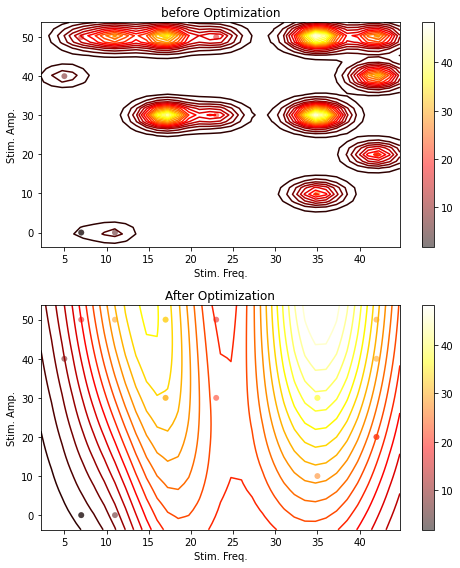

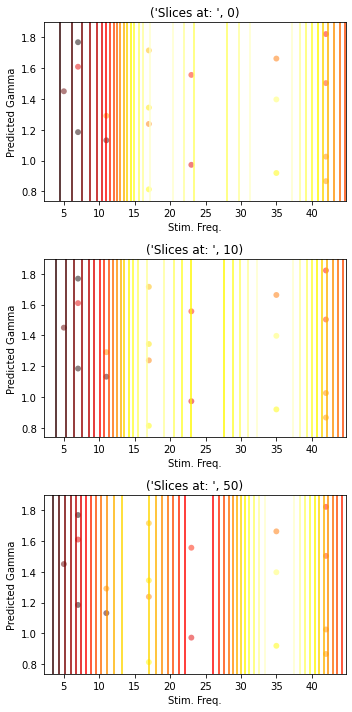

In [37]:
x_BaO_AF, y_BaO_AF, trained_model_BaO_AF = model.initialize_data_dr_sim(U1_init, X0_psd_init, X1_init, ker_BaO_AF, slice_dim, ylabel)

#### 1.3.2: Use the acquisition function to guide the next freq to optimize at

In [38]:
rand_freq_1d = np.random.choice(np.arange(1,43,1), size=(n_samples))
rand_freq_1d_sorted = np.sort(rand_freq_1d)
print(rand_freq_1d_sorted)
rand_amp_1d = np.random.choice(np.arange(1,51,1), size=(n_samples))
rand_amp_1d_sorted = np.sort(rand_amp_1d)
print(rand_amp_1d_sorted, np.shape(rand_amp_1d_sorted))

[ 1  1  1  1  2  3  3  3  3  3  4  5  5  5  5  5  6  6  6  6  6  6  7  7
  7  7  7  8  9  9  9 10 11 11 11 12 13 13 13 13 14 14 14 14 14 14 15 16
 16 16 16 16 16 16 17 18 18 18 18 18 19 19 19 20 21 21 21 21 21 21 22 22
 22 22 23 23 23 24 24 25 25 25 25 26 26 26 26 27 27 28 28 28 28 28 28 28
 28 29 30 30 30 30 30 31 31 31 31 31 32 32 32 32 33 33 33 33 34 34 34 34
 35 35 35 35 36 36 36 37 37 37 37 37 38 38 38 38 39 39 39 40 40 40 40 40
 41 41 42 42 42 42]
[ 1  2  4  4  4  4  4  5  5  5  6  6  6  7  7  7  7  8  8  8  9  9 10 10
 11 11 11 11 11 11 11 12 12 12 12 12 13 13 13 14 14 14 15 15 15 15 15 15
 16 17 17 17 17 17 17 17 17 18 18 18 19 19 19 20 20 20 21 21 21 21 21 22
 22 23 23 23 23 24 24 24 24 24 24 25 25 26 26 26 27 27 28 28 28 29 29 29
 30 30 30 31 31 33 33 33 33 34 34 34 34 35 35 36 36 37 37 38 38 38 39 39
 39 39 39 40 40 41 41 42 42 42 43 44 44 44 44 45 45 45 45 46 47 47 48 48
 48 48 49 49 49 49] (150,)


In [41]:
rand_preStimGamma_1d = np.random.choice(np.arange(0.8,11,0.1), size=(n_samples))
rand_preStimGamma_1d_sorted = np.sort(rand_preStimGamma_1d)
print(rand_preStimGamma_1d_sorted, np.shape(rand_preStimGamma_1d_sorted))

[ 0.8  0.9  0.9  1.1  1.1  1.2  1.4  1.5  1.6  1.6  1.6  1.6  1.9  2.1
  2.1  2.1  2.3  2.4  2.4  2.4  2.6  2.7  2.7  2.8  2.9  3.   3.   3.
  3.1  3.2  3.3  3.3  3.4  3.6  3.6  3.6  3.8  3.8  3.9  3.9  4.1  4.1
  4.1  4.2  4.3  4.3  4.3  4.3  4.4  4.4  4.4  4.6  4.7  4.9  4.9  5.
  5.   5.1  5.2  5.2  5.4  5.5  5.5  5.6  5.6  5.7  5.7  5.8  5.9  6.
  6.   6.   6.1  6.1  6.2  6.3  6.4  6.5  6.5  6.6  6.6  6.6  6.7  6.7
  6.8  6.9  6.9  6.9  7.   7.   7.1  7.3  7.4  7.5  7.6  7.8  7.8  7.9
  8.   8.   8.1  8.1  8.1  8.1  8.1  8.2  8.2  8.3  8.4  8.5  8.6  8.6
  8.6  8.7  8.7  8.7  8.8  8.9  9.   9.1  9.1  9.1  9.1  9.1  9.2  9.3
  9.3  9.3  9.4  9.4  9.5  9.6  9.6  9.7  9.8  9.8  9.8  9.8  9.9  9.9
 10.  10.5 10.5 10.6 10.6 10.7 10.8 10.8 10.9 10.9] (150,)


In [42]:
print(np.shape(rand_freq_1d_sorted), np.shape(rand_amp_1d_sorted))

testX_BaO = np.array([rand_freq_1d_sorted, rand_amp_1d_sorted, rand_preStimGamma_1d_sorted])
print(np.shape(testX_BaO))
testX = np.transpose(testX_BaO)
print(np.shape(testX))

(150,) (150,)
(3, 150)
(150, 3)


In [44]:
# a loop to optimize at every acquistion for 50 iteration and re-optimization, then plot before and after.
ucb = np.empty((1, n_samples))
ucb_sample = np.empty((n_acquisition, 3))
postStimGamma_predicted_from_firstModel = np.empty((n_acquisition, 1))
print(np.shape(ucb))

nu = 0.1
print("nu set at: ", nu)

for a in range(1, n_acquisition):
    simY_BaO_AF = np.empty((1, n_samples))
    simMse_BaO_AF = np.empty((1, n_samples))
    simY_BaO_AF, simMse_BaO_AF= trained_model_BaO_AF.predict(testX);
    
    ucb= model.acquisition_function(simY_BaO_AF, simMse_BaO_AF, nu, 1)
    max_ucb = np.max(ucb, axis=0)
    argMax_ucb = ucb.argmax()

    # find the values of argMax_ucb in the sample grid
    ucb_sample[a,:] = testX[argMax_ucb]
    ucb_sample_reshaped = np.reshape(ucb_sample[a,:], (1,3))
    
    # Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model
    postStimGamma_predicted_from_firstModel[a] = trained_model_BaO.posterior_samples_f(ucb_sample_reshaped, full_cov=True, size=1)[:,0,0]
    # simY_BaO, simMse_BaO =  trained_model_BaO.predict(ucb_sample_reshaped);
    
    # append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points
    next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(ucb_sample[a,0])], 'Stim_2':[int(ucb_sample[a,1])]})
    U1_init = pd.concat([U1_init, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2'], axis=0)

    # sum_preStim_gamma
    next_preStimGamma = pd.DataFrame({'sum_preStim_gamma':[int(ucb_sample[a,2])]})
    X0_psd_init = pd.concat([X0_psd_init, next_preStimGamma], ignore_index=True, axis=0)
    
    # Append U1_init and X0_psd_init
    U1_X0_init = U1_init.join(X0_psd_init)
    
    # Concatenate the first model predicted postStimGamma 
    next_postStimGamma = np.empty((1,1))
    next_postStimGamma[0,:] = [postStimGamma_predicted_from_firstModel[a]]
    X1_init = np.append(X1_init, next_postStimGamma, axis=0)
    
    # trained_model_BaO_AF.add_observer()
    # trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000)
    trained_model_BaO_AF = model.bayes_opt_update_state(U1_X0_init, X1_init, ker_BaO_AF)
    
    

(1, 150)
nu set at:  0.1
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s06  0006   7.713626e+01   6.725520e-04 
    00s15  0013   7.712429e+01   4.444978e-04 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s17  0014   7.712207e+01   1.072169e-04 
    00s34  0031   7.712134e+01   1.135696e-12 
Runtime:     00s34
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0002   8.537693e+01   9.603364e-01 
    00s16  0010   8.345564e+01   6.409105e-04 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s18  0011   8.344173e+01   4.733784e-04 
    00s19  0012   8.343374e+01   1.833122e-05 
    00s36  0032   8.343124e+01   8.715959e-12 
Runtime:     00s36
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s15  0007   8.709585e+01   3.199731e-06 
    00s17  0008   8.709555e+01   7.659355e-06 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s41  0023   8.708689e+01   1.212012e-11 
Runtime:     00s41
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s09  0004   8.999350e+01   1.747254e-05 
    00s16  0007   8.999306e+01   2.001123e-07 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s19  0008   8.999306e+01   1.464443e-07 
    00s63  0032   8.999275e+01   9.281653e-11 
Runtime:     00s63
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s08  0003   9.251362e+01   2.532246e-04 
    00s16  0006   9.250876e+01   1.676993e-06 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s30  0014   9.250806e+01   1.085626e-09 
Runtime:     00s30
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0002   9.512547e+01   3.935127e-02 
    00s16  0006   9.504563e+01   1.092097e-06 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



    00s26  0012   9.504499e+01   4.433393e-09 
Runtime:     00s26
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s17  0004   9.736818e+01   1.187286e-06 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



    00s41  0015   9.736790e+01   1.850592e-08 
Runtime:     00s41
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0002   9.969389e+01   5.374328e-04 
    00s06  0006   9.968858e+01   7.271401e-07 
    00s14  0008   9.968856e+01   1.064264e-06 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s19  0009   9.968848e+01   6.712387e-06 
    00s57  0029   9.968750e+01   2.229986e-11 
Runtime:     00s57
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0002   1.019421e+02   1.007056e-03 
    00s16  0007   1.019396e+02   2.303821e-07 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s26  0014   1.019395e+02   5.432990e-09 
Runtime:     00s26
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0006   1.043146e+02   1.739637e-06 
    00s19  0010   1.043138e+02   1.355578e-05 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



    00s33  0015   1.043137e+02   2.130435e-09 
Runtime:     00s33
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0002   1.067276e+02   4.029262e-02 
    00s07  0004   1.066771e+02   1.023976e-04 
    00s13  0006   1.066769e+02   1.915300e-07 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



    00s43  0015   1.066768e+02   2.906158e-09 
Runtime:     00s43
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0001   1.106709e+02   1.831631e-02 
    00s18  0007   1.105913e+02   6.879114e-06 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



    00s33  0015   1.105905e+02   1.592961e-10 
Runtime:     00s33
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s16  0006   1.131206e+02   1.529758e-06  

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s30  0014   1.131198e+02   5.409511e-12 
Runtime:     00s30
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s13  0005   1.155507e+02   1.036927e-07 
    00s17  0007   1.155507e+02   1.005675e-07 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



    00s24  0013   1.155507e+02   4.922196e-11 
Runtime:     00s24
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s14  0004   1.189255e+02   1.627196e-06 
    00s17  0005   1.189255e+02   5.309944e-07 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s31  0013   1.189252e+02   1.194632e-10 
Runtime:     00s31
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s09  0004   1.215210e+02   1.081605e-05 
    00s17  0008   1.215210e+02   1.712163e-06 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s23  0012   1.215209e+02   2.728368e-10 
Runtime:     00s23
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s08  0005   1.238302e+02   1.103395e-07 
    00s16  0007   1.238302e+02   3.403689e-08 
Runtime:     00s16
Optimization status: Converged



 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0002   1.268152e+02   1.099097e-01 
    00s16  0005   1.266514e+02   3.721335e-07 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



    00s31  0013   1.266512e+02   4.510934e-11 
Runtime:     00s31
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s17  0008   1.289092e+02   1.195056e-08 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



    00s27  0013   1.289092e+02   5.327029e-09 
Runtime:     00s27
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s08  0004   1.317252e+02   3.122884e-07 
    00s17  0008   1.317251e+02   3.489027e-06 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s25  0013   1.317251e+02   1.255512e-12 
Runtime:     00s25
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s11  0005   1.339260e+02   1.637927e-07 
    00s17  0008   1.339260e+02   6.534052e-09 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s18  0009   1.339260e+02   6.534052e-09 
Runtime:     00s18
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s12  0006   1.361037e+02   1.635714e-09  
    00s13  0007   1.361037e+02   1.635714e-09 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



Runtime:     00s13
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0001   1.399207e+02   1.028139e-02 
    00s18  0010   1.398883e+02   1.768949e-05 
    00s23  0014   1.398882e+02   1.037231e-10 
Runtime:     00s23
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s10  0007   1.420827e+02   9.611817e-10 
    00s13  0009   1.420827e+02   1.417042e-09 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



Runtime:     00s13
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   1.443629e+02           nan 
    00s07  0004   1.443562e+02   3.221149e-04 
    00s13  0007   1.443558e+02   1.383062e-08 
    00s19  0010   1.443558e+02   8.388883e-08 
    00s33  0022   1.443558e+02   2.224196e-09 
Runtime:     00s33
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s09  0006   1.465133e+02   1.895809e-09 
    00s12  0008   1.465133e+02   1.483785e-09 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



Runtime:     00s12
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s06  0004   1.486536e+02   5.074655e-04 
    00s10  0007   1.486530e+02   5.379524e-09 
    00s14  0009   1.486530e+02   8.958189e-09 
Runtime:     00s14
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s15  0007   1.516737e+02   6.578166e-08  
    00s16  0008   1.516737e+02   3.496582e-07 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s18  0009   1.516737e+02   1.908942e-06 
    00s25  0014   1.516736e+02   1.366826e-09 
Runtime:     00s25
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0004   1.557162e+02   2.434138e-06 
    00s16  0011   1.557161e+02   2.249502e-07 
    00s16  0012   1.557161e+02   1.121860e-09 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s18  0014   1.557161e+02   9.459893e-10 
Runtime:     00s18
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0002   1.581165e+02   1.762252e-01 
    00s15  0005   1.579241e+02   2.460116e-09 
    00s17  0006   1.579241e+02   2.419801e-09 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s22  0009   1.579241e+02   7.624103e-09 
Runtime:     00s22
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0002   1.610911e+02   1.507508e-02 
    00s16  0009   1.610438e+02   1.086664e-06  

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s19  0011   1.610437e+02   7.773975e-08 
    00s22  0013   1.610437e+02   7.900609e-10 
Runtime:     00s22
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0005   1.632185e+02   2.547622e-07 
    00s08  0008   1.632185e+02   7.311035e-10 
Runtime:     00s08
Optimization status: Converged



 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s06  0002   1.658308e+02   5.043734e-02 
    00s26  0013   1.657401e+02   9.581426e-09 
Runtime:     00s26
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s14  0007   1.692856e+02   1.167679e-07 
    00s16  0008   1.692856e+02   3.103415e-07 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s23  0013   1.692855e+02   1.222339e-08 
Runtime:     00s23
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0003   1.715846e+02   8.990643e-07 
    00s10  0005   1.715846e+02   1.090903e-08    00s14  0006   1.715846e+02   1.074157e-08 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s16  0007   1.715846e+02   1.262401e-08 
    00s29  0013   1.715846e+02   4.832849e-09 
Runtime:     00s29
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s13  0006   1.737491e+02   1.036760e-09 
    00s15  0007   1.737491e+02   1.036760e-09 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



Runtime:     00s15
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s11  0004   1.759012e+02   1.097566e-04 
    00s22  0007   1.759011e+02   6.522597e-10 
Runtime:     00s22
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s17  0007   1.784644e+02   3.719954e-08 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s19  0009   1.784644e+02   1.002082e-07 
    00s21  0012   1.784644e+02   1.162840e-09 
Runtime:     00s21
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s10  0003   1.806927e+02   6.996504e-05 
    00s15  0005   1.806926e+02   6.255910e-09 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s23  0008   1.806926e+02   1.196521e-08 
Runtime:     00s23
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s14  0005   1.838408e+02   1.041329e-07 
    00s17  0006   1.838408e+02   1.032684e-07 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s19  0007   1.838408e+02   1.272784e-07 
    00s30  0014   1.838408e+02   4.215969e-11 
Runtime:     00s30
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s06  0003   1.861865e+02   7.232532e-06 
    00s16  0008   1.861864e+02   2.297308e-08 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s21  0012   1.861864e+02   1.727386e-09 
Runtime:     00s21
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0003   1.889605e+02   3.227873e-06 
    00s13  0008   1.889605e+02   8.915099e-08 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



Runtime:     00s13
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0001   1.919753e+02   1.750455e-03 
    00s05  0003   1.919721e+02   1.859934e-05 
    00s12  0008   1.919721e+02   6.727521e-10 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



Runtime:     00s12
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0002   1.942394e+02   6.807338e-02 
    00s05  0003   1.941329e+02   2.159271e-05 
    00s08  0005   1.941329e+02   2.814012e-09 
    00s12  0008   1.941329e+02   3.708922e-09 
Runtime:     00s12
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s12  0007   1.962825e+02   1.115876e-08 
    00s13  0008   1.962825e+02   1.115876e-08 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



Runtime:     00s13
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s12  0009   2.025905e+02   9.862969e-06 
    00s15  0013   2.025904e+02   1.854008e-09 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s16  0014   2.025904e+02   1.854008e-09 
Runtime:     00s16
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s13  0005   2.049832e+02   8.195112e-09 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s17  0006   2.049832e+02   7.110915e-09 
    00s21  0007   2.049832e+02   7.110915e-09 
Runtime:     00s21
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s16  0004   2.079521e+02   1.352227e-05 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



    00s37  0013   2.079521e+02   1.209694e-08 
Runtime:     00s37
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s11  0005   2.101483e+02   1.730374e-09  
    00s17  0008   2.101483e+02   1.258002e-08 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s19  0009   2.101483e+02   1.258002e-08 
Runtime:     00s19
Optimization status: Converged



#### 1.3.3: Plot before and after optimization 

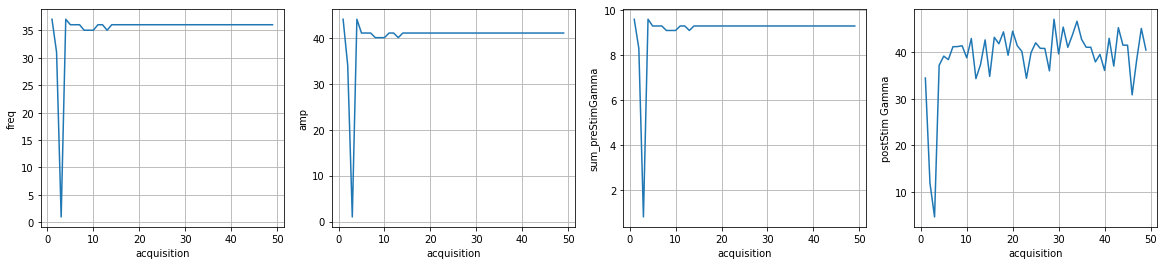

In [50]:
fig = plt.figure(figsize=(20,4));
plt.subplot(1,4,1)
plt.plot(np.arange(1,50), ucb_sample[1:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.grid(visible=True)

plt.subplot(1,4,2)
plt.plot(np.arange(1,50), ucb_sample[1:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.grid(visible=True)

plt.subplot(1,4,3)
plt.plot(np.arange(1,50), ucb_sample[1:,2], label=r"sum_preStimGamma")
plt.xlabel("acquisition")
plt.ylabel("sum_preStimGamma")
plt.grid(visible=True)

plt.subplot(1,4,4)
plt.plot(np.arange(1,50), postStimGamma_predicted_from_firstModel[1:,], label=r"postStimGamma")
plt.xlabel("acquisition")
plt.ylabel("postStim Gamma")
plt.grid(visible=True)
plt.show();
# plot the model's max (freq, amp, postStim gamma) at each iteration

In [47]:
print(ucb_sample)
print(ucb_sample[1:,0])
print(ucb_sample[1:,1])
print(ucb_sample[1:,2])

[[39.50686004 39.03508977 38.12814274]
 [37.         44.          9.6       ]
 [31.         34.          8.3       ]
 [ 1.          1.          0.8       ]
 [37.         44.          9.6       ]
 [36.         41.          9.3       ]
 [36.         41.          9.3       ]
 [36.         41.          9.3       ]
 [35.         40.          9.1       ]
 [35.         40.          9.1       ]
 [35.         40.          9.1       ]
 [36.         41.          9.3       ]
 [36.         41.          9.3       ]
 [35.         40.          9.1       ]
 [36.         41.          9.3       ]
 [36.         41.          9.3       ]
 [36.         41.          9.3       ]
 [36.         41.          9.3       ]
 [36.         41.          9.3       ]
 [36.         41.          9.3       ]
 [36.         41.          9.3       ]
 [36.         41.          9.3       ]
 [36.         41.          9.3       ]
 [36.         41.          9.3       ]
 [36.         41.          9.3       ]
 [36.         41.        

In [48]:
print(postStimGamma_predicted_from_firstModel[1:])

[[34.41047595]
 [11.96449443]
 [ 4.74432606]
 [37.11636018]
 [39.08369927]
 [38.34034298]
 [41.09021717]
 [41.11866273]
 [41.29661447]
 [38.73023937]
 [42.8438112 ]
 [34.27182265]
 [37.26583062]
 [42.54769442]
 [34.75601452]
 [43.09697065]
 [41.71926904]
 [44.26678472]
 [39.26662841]
 [44.41235522]
 [41.30156564]
 [40.09504054]
 [34.35050915]
 [39.83352629]
 [41.92633941]
 [40.74977829]
 [40.72041375]
 [35.9345308 ]
 [46.95778134]
 [39.5595201 ]
 [45.28279584]
 [40.96761611]
 [43.58113375]
 [46.52977014]
 [42.65868339]
 [40.97593356]
 [40.97776959]
 [37.85091681]
 [39.44920993]
 [36.02970664]
 [42.88701494]
 [36.95474056]
 [45.16320381]
 [41.42673333]
 [41.41668493]
 [30.8123165 ]
 [38.34268759]
 [44.99907111]
 [40.38905087]]


### 1.4: Dynamic BaO

In [51]:
dynamic_model = state_dr_gp()

In [52]:
# Get the input U1 and X0_psd, and the X1 outputs
X0_coords, U1_dynamic, X1_dynamic, lower_bound, upper_bound, X0_psd_dynamic, N_trials = dynamic_model.gp_model(path)

#### 1.4.1: We will not use preStimGamma, and instead we will train on most recent 20 samples so the model is not affected by brain state changes.

In [53]:
U1_init_dynamic = U1_dynamic.loc[0:n_burn_in-1,:]
X1_init_dynamic = X1_dynamic[0:n_burn_in,:]
X0_psd_init_dynamic = hill_sum_preStim_gamma_pd.loc[0:n_burn_in-1]

print('freq and amplitude used are: \n', U1_init_dynamic, np.shape(U1_init_dynamic))
print('Sum preStim gamma are: \n', X0_psd_init_dynamic)
print('sum postStim gamma are: \n', X1_init_dynamic, np.shape(X1_init_dynamic))

freq and amplitude used are: 
     Stim_1  Stim_2
0       17      30
1       42      40
2       35      30
3       23      50
4       42      50
5       35      50
6       11       0
7        7       0
8       17      30
9       11      50
10      17      50
11      35      30
12       5      40
13      42      20
14      23      30
15       7      50
16      35      10
17      17      50
18       7       0
19      42      20 (20, 2)
Sum preStim gamma are: 
     sum_preStim_gamma
0            0.813800
1            0.866848
2            0.919897
3            0.972945
4            1.025994
5            1.079042
6            1.132091
7            1.185140
8            1.238188
9            1.291237
10           1.344285
11           1.397334
12           1.450383
13           1.503431
14           1.556480
15           1.609528
16           1.662577
17           1.715626
18           1.768674
19           1.821723
sum postStim gamma are: 
 [[36.44022473]
 [29.52148839]
 [36.13920654]
 [16

In [61]:
testX_Dynamic_BaO = np.array([rand_freq_1d_sorted, rand_amp_1d_sorted, rand_preStimGamma_1d_sorted])
print(np.shape(testX_Dynamic_BaO))
testX_Dynamic = np.transpose(testX_Dynamic_BaO)
print(np.shape(testX_Dynamic))

(3, 150)
(150, 3)


In [62]:
ker_BaO_dynamic = GPy.kern.Matern52(input_dim=3, variance=3., lengthscale=2.,ARD=True) + GPy.kern.White(2)

In [63]:
print(np.shape(U1_init_dynamic))
print(np.shape(X1_init_dynamic))
print(np.shape(X0_psd_init_dynamic))

(20, 2)
(20, 1)
(20, 1)


In [64]:
print(type(U1_init_dynamic),type(X1_init_dynamic),type(X0_psd_init_dynamic) )

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'>


#### 1.4.2: Initial training of the Dynamic model

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x2a2574a9640>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2a2574a8160>]}

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0005   3.518658e+02   9.088650e+02 
    00s10  0010   9.781584e+01   1.119830e+00 
    00s18  0015   7.856831e+01   2.686676e-03 
    00s19  0016   7.753448e+01   2.657047e-03 
    00s68  0088   6.946105e+01   3.651995e-09 
Runtime:     00s68
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x2a259a923d0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2a259a89250>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x2a25ecb0490>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2a25eca63d0>]}

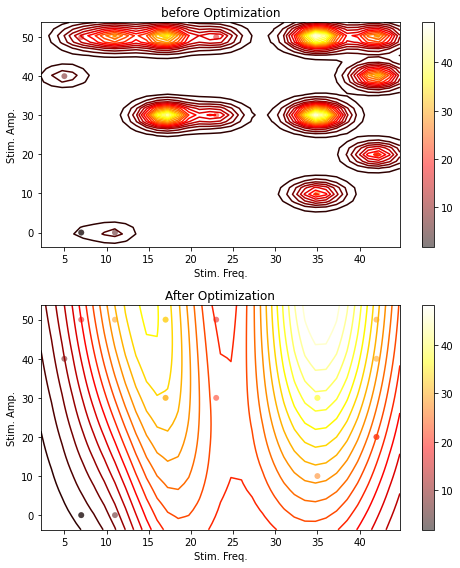

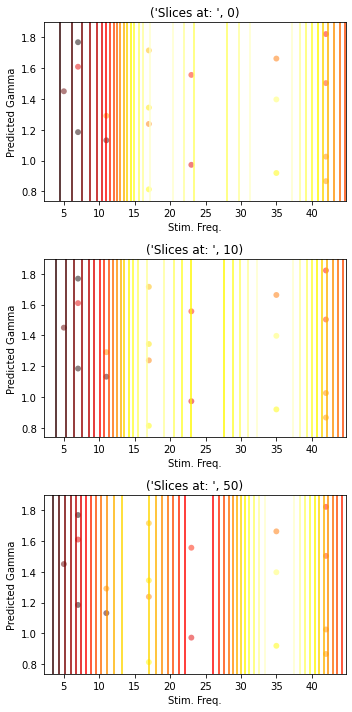

In [65]:
# Initialize a dynamic model:
x_BaO_dynamic, y_BaO_dynamic, trained_model_BaO_Dynamic = dynamic_model.initialize_data_dr_sim(U1_init_dynamic, X0_psd_init_dynamic, X1_init_dynamic, 
                                                                                               ker_BaO_dynamic, slice_dim, ylabel)
# trained_model_BaO_Dynamic = GPy.models.GPRegression(U1_init_dynamic,X1_init_dynamic, ker_BaO_dynamic)
# trained_model_BaO_Dynamic.optimize(messages=True,max_f_eval = 1000);

# figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
# canvas = trained_model_BaO_Dynamic.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
#                         title='After Optimization');
# display(canvas)
# ax = plt.gca()
# PCM = ax.get_children()[0]
# plt.colorbar(PCM, ax=ax)

# # Plotting slices of the model at amplitudes of 0, 10, and 50
# slices = [0, 10, 50]
# figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

# for i, y in zip(range(3), slices):
#     print((1,y));

# canvas = trained_model_BaO_Dynamic.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
#                     xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

# display(canvas);
# x_BaO_dynamic, y_BaO_dynamic, trained_model_BaO_Dynamic = dynamic_model.initialize_data_dr_sim(U1_init_dynamic, X0_psd_init_dynamic, X1_init_dynamic, 
# ker_BaO, slice_dim, ylabel)

In [66]:
simY_BaO_dynamic, simMse_BaO_dynamic= trained_model_BaO_Dynamic.predict(testX_Dynamic);
# print(simY_BaO_dynamic, simMse_BaO_dynamic)
nu = 0.1
ucb_dynamic= dynamic_model.acquisition_function(simY_BaO_dynamic, simMse_BaO_dynamic, nu, 1)
# print(ucb_dynamic, np.shape(ucb_dynamic))
max_ucb_dynamic = np.max(ucb_dynamic, axis=0)
print(max_ucb_dynamic)
argMax_ucb_dynamic = ucb_dynamic.argmax()
print(argMax_ucb_dynamic)

[49.90018948]
131


In [67]:
ucb_sample_dynamic = np.empty((n_acquisition, 3))
ucb_sample_dynamic[0, :] = testX_Dynamic_BaO[:, argMax_ucb_dynamic]
print(ucb_sample_dynamic[0,:])
ucb_sample_reshaped = np.reshape(ucb_sample_dynamic[0,:], (1,3))

[37.  44.   9.6]


#### 1.4.3: Using the acquisition function to guide the training of the Dynamic model

In [68]:
ucb_dynamic = np.empty((1, n_samples))
ucb_sample_dynamic = np.empty((n_acquisition, 3))
postStimGamma_predicted_from_firstModel_dynamic = np.empty((n_acquisition, 1))
print(np.shape(ucb_dynamic))

nu = 0.1
print("nu set at: ", nu)

for a in range(1, n_acquisition):
    simY_BaO_dynamic = np.empty((1, n_samples))
    simMse_BaO_dynamic = np.empty((1, n_samples))
    
    simY_BaO_dynamic, simMse_BaO_dynamic= trained_model_BaO_Dynamic.predict(testX_Dynamic);
    
    ucb_dynamic= dynamic_model.acquisition_function(simY_BaO_dynamic, simMse_BaO_dynamic, nu, 1)
    max_ucb_dynamic = np.max(ucb_dynamic, axis=0)
    print(max_ucb_dynamic)
    argMax_ucb_dynamic = ucb_dynamic.argmax()
    print(argMax_ucb_dynamic)
    # find the values of argMax_ucb in the sample grid
    ucb_sample_dynamic[a, :] = testX_Dynamic_BaO[:, argMax_ucb_dynamic]
    print(ucb_sample_dynamic[a,:])
    ucb_sample_reshaped = np.reshape(ucb_sample_dynamic[a,:], (1,3))
    
    # Predicting the Acquisition Func. suggest next freq/amp/preStimGamma from the frist model
    postStimGamma_predicted_from_firstModel_dynamic[a] = trained_model_BaO.posterior_samples_f(ucb_sample_reshaped, full_cov=True, size=1)[:,0,0]
    # simY_BaO_dynamic, simMse_BaO_dynamic =  trained_model_BaO_Dynamic.predict(ucb_sample_reshaped);
    
    # append the acquisition function suggested, and first model predicted mean freq/amp/preStimGamma and mean postStimGamma from state_est_BaO to the burn-in points
    next_sample_to_optimize = pd.DataFrame({'Stim_1':[int(ucb_sample_dynamic[a,0])], 'Stim_2':[int(ucb_sample_dynamic[a,1])]})
    U1_init_dynamic = pd.concat([U1_init_dynamic, next_sample_to_optimize], ignore_index=True, keys=['Stim_1','Stim_2'], axis=0)
    U1_init_dynamic_twenty = U1_init_dynamic.loc[a:a+int(n_burn_in),:]
    
    # sum_preStim_gamma
    next_preStimGamma_dynamic = pd.DataFrame({'sum_preStim_gamma':[int(ucb_sample_dynamic[a,2])]})
    X0_psd_init_dynamic = pd.concat([X0_psd_init_dynamic, next_preStimGamma_dynamic], ignore_index=True, axis=0)
    X0_psd_init_dynamic_twenty = X0_psd_init_dynamic.loc[a:a+int(n_burn_in),:]
    
    # Append U1_init and X0_psd_init
    U1_X0_init_dynamic_twenty = U1_init_dynamic_twenty.join(X0_psd_init_dynamic_twenty)
    
    # Concatenate the first model predicted postStimGamma 
    next_postStimGamma = np.empty((1,1))
    next_postStimGamma[0,:] = [postStimGamma_predicted_from_firstModel_dynamic[a]]
    X1_init_dynamic = np.append(X1_init_dynamic, next_postStimGamma, axis=0)
    
    X1_init_dynamic_twenty = X1_init_dynamic[a:a+int(n_burn_in),:]
    print(np.shape(U1_init_dynamic_twenty),np.shape(X1_init_dynamic_twenty))
    # trained_model_BaO_AF.add_observer()
    # trained_model_BaO_AF.optimize(messages=True,max_f_eval = 1000)
    trained_model_BaO_Dynamic = dynamic_model.bayes_opt_update_state(U1_X0_init_dynamic_twenty, X1_init_dynamic_twenty, ker_BaO_dynamic)
    
    

(1, 150)
nu set at:  0.1
[49.90018948]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0004   6.647075e+01   1.083123e-06 
    00s12  0010   6.647049e+01   2.236482e-07 
    00s17  0013   6.647049e+01   1.097932e-07 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s18  0014   6.647049e+01   3.565554e-07 
    00s31  0026   6.646955e+01   5.613882e-11 
Runtime:     00s31
Optimization status: Converged

[45.63116468]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0001   6.878019e+01   2.118783e-01 
    00s08  0006   6.837943e+01   7.060213e-05 


 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s18  0014   6.836134e+01   2.536252e-08 
    00s19  0015   6.836134e+01   4.085338e-08 
    00s38  0035   6.836030e+01   3.927527e-09 
Runtime:     00s38
Optimization status: Converged

[48.19485464]
107
[31.  34.   8.3]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0002   7.181392e+01   2.477755e-01 
    00s06  0005   7.133076e+01   5.816632e-04 
    00s16  0013   7.130780e+01   3.993456e-06 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



    00s19  0015   7.130777e+01   2.700800e-08 
    00s31  0030   7.130659e+01   2.070315e-09 
Runtime:     00s31
Optimization status: Converged

[48.89715788]
0
[1.  1.  0.8]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s06  0006   7.140937e+01   1.148653e-05 
    00s13  0010   7.140470e+01   1.258748e-05 
    00s16  0012   7.140457e+01   4.602678e-08 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s18  0013   7.140456e+01   4.800612e-08 
    00s42  0027   7.140295e+01   2.571240e-10 
Runtime:     00s42
Optimization status: Converged

[46.30231424]
125
[36.  41.   9.3]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0002   7.188998e+01   1.345918e-02 
    00s15  0007   7.171880e+01   1.090123e-06 
    00s18  0008   7.171872e+01   3.976176e-06 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s28  0014   7.171821e+01   8.295002e-09 
Runtime:     00s28
Optimization status: Converged

[46.59818133]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0001   6.915921e+01   1.610841e-02 
    00s04  0004   6.893533e+01   8.037928e-04 
    00s18  0011   6.889625e+01   1.533834e-05 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



    00s46  0029   6.882026e+01   7.246049e-11 
Runtime:     00s46
Optimization status: Converged

[44.18996265]
148
[42.  49.  10.9]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0002   6.906758e+01   4.630704e-03 
    00s11  0005   6.904641e+01   2.075779e-04 
    00s18  0008   6.902086e+01   3.434856e-03 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



    00s44  0027   6.896476e+01   7.557144e-12 
Runtime:     00s44
Optimization status: Converged

[42.69033776]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0005   7.064737e+01   1.045314e-05 
    00s17  0010   7.064630e+01   2.812239e-04 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s19  0011   7.064525e+01   4.133711e-04 
    00s36  0032   7.063487e+01   4.713238e-13 
Runtime:     00s36
Optimization status: Converged

[45.34633435]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s13  0006   7.043631e+01   6.587975e-06 
    00s16  0007   7.043504e+01   4.019898e-05 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s28  0015   7.042609e+01   5.097764e-09 
Runtime:     00s28
Optimization status: Converged

[52.68228275]
47
[16.  15.   4.3]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s18  0010   7.115601e+01   1.053432e-04 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s19  0011   7.115413e+01   3.471109e-06 
    00s39  0025   7.114300e+01   1.287158e-11 
Runtime:     00s39
Optimization status: Converged

[45.78909564]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s06  0004   7.058333e+01   8.365747e-03 
    00s16  0013   7.055014e+01   1.395631e-07 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s19  0014   7.055014e+01   1.046113e-07 
    00s30  0025   7.054770e+01   8.736337e-11 
Runtime:     00s30
Optimization status: Converged

[45.47140029]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s12  0008   6.987109e+01   4.078049e-04 
    00s16  0011   6.986509e+01   1.137744e-06 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



    00s19  0013   6.986508e+01   7.645452e-07 
    00s38  0030   6.985831e+01   3.258277e-12 
Runtime:     00s38
Optimization status: Converged

[45.14188249]
135
[38.  45.   9.8]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s11  0008   6.918803e+01   3.974822e-06 
    00s16  0012   6.918623e+01   9.662088e-12 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



Runtime:     00s16
Optimization status: Converged

[44.75570231]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s10  0007   6.904986e+01   9.386236e-07 
    00s18  0012   6.904964e+01   6.884154e-09 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



    00s30  0024   6.904945e+01   1.669333e-12 
Runtime:     00s30
Optimization status: Converged

[45.03186367]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s14  0007   6.852575e+01   2.297611e-05 
    00s15  0008   6.852515e+01   4.273874e-05 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s17  0009   6.852447e+01   2.322367e-05 
    00s39  0026   6.852154e+01   6.756754e-13 
Runtime:     00s39
Optimization status: Converged

[75.874215]
76
[23.  23.   6.4]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s09  0006   6.838846e+01   4.554935e-05 
    00s16  0011   6.838274e+01   7.420800e-07 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s19  0013   6.838264e+01   5.561621e-06 
    00s34  0025   6.837200e+01   3.260180e-13 
Runtime:     00s34
Optimization status: Converged

[45.65072535]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0004   6.737992e+01   6.987766e-05 
    00s16  0010   6.733523e+01   1.034816e-04 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s23  0016   6.733352e+01   2.739812e-08 
Runtime:     00s23
Optimization status: Converged

[45.41135332]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0002   6.467473e+01   1.549242e-03 
    00s13  0008   6.462549e+01   5.171903e-03 
    00s16  0010   6.448938e+01   2.444178e-02 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s19  0012   6.681525e+01   1.356750e-01 
    00s67  0059   6.390174e+01   2.651864e-09 
Runtime:     00s67
Optimization status: Converged

[45.14375646]
135
[38.  45.   9.8]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0003   6.389803e+01   9.645116e-05 
    00s08  0006   6.389771e+01   6.567735e-07 
    00s17  0013   6.388797e+01   4.881391e-04 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s19  0014   6.388649e+01   7.655445e-05 
    00s25  0020   6.388625e+01   9.570018e-10 
Runtime:     00s25
Optimization status: Converged

[76.89894888]
30
[ 9.  11.   3.3]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0003   6.499104e+01   3.249365e-04 
    00s16  0010   6.498893e+01   2.044714e-05 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s19  0012   6.498827e+01   7.197051e-05 
    00s31  0020   6.498742e+01   2.604878e-12 
Runtime:     00s31
Optimization status: Converged

[45.41366673]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0001   6.490895e+01   1.189228e-04 
    00s17  0005   6.490817e+01   2.408978e-10 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



    00s21  0007   6.490817e+01   1.976336e-10 
Runtime:     00s21
Optimization status: Converged

[45.31562192]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0003   6.500717e+01   4.952259e-07 
    00s10  0005   6.500717e+01   1.045828e-10 
    00s13  0006   6.500717e+01   1.045828e-10 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



Runtime:     00s13
Optimization status: Converged

[45.3571767]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0001   6.379098e+01   3.419104e-03 
    00s04  0002   6.377185e+01   6.380672e-04 
    00s16  0007   6.376812e+01   1.104970e-05 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s19  0008   6.376782e+01   3.700285e-05 
    00s39  0021   6.374988e+01   9.608788e-12 
Runtime:     00s39
Optimization status: Converged

[58.37085033]
101
[30.  33.   8.1]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s09  0004   6.367115e+01   3.134970e-05 
    00s16  0007   6.367096e+01   7.200211e-09 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s18  0008   6.367096e+01   9.823126e-09 
    00s20  0009   6.367096e+01   9.823126e-09 
Runtime:     00s20
Optimization status: Converged

[103.60533846]
0
[1.  1.  0.8]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0002   6.379031e+01   2.688626e-03 
    00s14  0006   6.377375e+01   5.218106e-07 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s18  0008   6.377373e+01   1.320680e-06 
    00s32  0019   6.375920e+01   5.934144e-11 
Runtime:     00s32
Optimization status: Converged

[48.04146384]
120
[35.  39.   9.1]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s17  0009   6.476779e+01   5.821882e-05 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



    00s19  0011   6.476532e+01   4.157658e-04 
    00s31  0019   6.475949e+01   6.996446e-11 
Runtime:     00s31
Optimization status: Converged

[45.1882003]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0003   6.396340e+01   2.047107e-04 
    00s16  0011   6.396046e+01   9.562096e-05 
    00s19  0013   6.395766e+01   1.105296e-04 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s30  0021   6.395648e+01   1.019691e-13 
Runtime:     00s30
Optimization status: Converged

[63.93575663]
148
[42.  49.  10.9]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0006   6.396935e+01   2.249827e-08 
    00s08  0007   6.396935e+01   2.249827e-08 
Runtime:     00s08
Optimization status: Converged

[44.35247203]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0003   6.507708e+01   4.313202e-04 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s09  0008   6.507584e+01   8.996434e-09 
Runtime:     00s09
Optimization status: Converged

[44.39725356]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0002   6.419722e+01   2.250440e-03 
    00s14  0012   6.418973e+01   2.120672e-04 
    00s17  0014   6.418751e+01   1.306168e-04 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s18  0015   6.418728e+01   1.158447e-04 
    00s23  0020   6.418690e+01   1.285058e-11 
Runtime:     00s23
Optimization status: Converged

[67.28721212]
47
[16.  15.   4.3]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   6.538507e+01           nan 
    00s08  0008   6.535098e+01   5.386165e-06 
    00s17  0016   6.534383e+01   1.051779e-04 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s22  0020   6.534313e+01   4.311655e-11 
Runtime:     00s22
Optimization status: Converged

[44.8462423]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0002   6.551402e+01   2.913031e-03 
    00s09  0007   6.549977e+01   2.284788e-10 
Runtime:     00s09
Optimization status: Converged

[44.96783708]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0001   6.612449e+01   6.178772e-03 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s02  0002   6.610910e+01   6.871412e-03 
    00s07  0006   6.609078e+01   1.240691e-08 
    00s09  0008   6.609078e+01   7.440563e-09 
Runtime:     00s09
Optimization status: Converged

[45.61957842]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0003   6.571386e+01   6.992227e-05 
    00s07  0007   6.571327e+01   3.706708e-10 
Runtime:     00s07
Optimization status: Converged

[45.13656362]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   6.469065e+01           nan 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s08  0006   6.461009e+01   1.289362e-08 
    00s17  0015   6.460984e+01   6.147025e-06 
    00s22  0019   6.460982e+01   9.083428e-11 
Runtime:     00s22
Optimization status: Converged

[44.12400281]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0006   6.315311e+01   5.382370e-07 
    00s18  0016   6.314982e+01   3.357209e-06 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



    00s21  0020   6.314979e+01   9.870112e-12 
Runtime:     00s21
Optimization status: Converged

[53.92250264]
76
[23.  23.   6.4]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0001   6.465714e+01   1.226941e-04 
    00s15  0011   6.465618e+01   5.443458e-05 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



    00s19  0013   6.465543e+01   4.664288e-05 
    00s26  0019   6.465522e+01   1.923383e-10 
Runtime:     00s26
Optimization status: Converged

[43.91166141]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0002   6.609478e+01   1.076338e-02 
    00s12  0008   6.602637e+01   1.010091e-09 
Runtime:     00s12
Optimization status: Converged



 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


[44.1418295]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0002   6.554675e+01   4.147265e-02 
    00s07  0007   6.545804e+01   2.569939e-08 
    00s17  0015   6.545769e+01   7.882923e-12 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s18  0016   6.545769e+01   7.882923e-12 
Runtime:     00s18
Optimization status: Converged

[44.8259756]
134
[38.  44.   9.8]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0004   6.402117e+01   3.731862e-04 
    00s16  0014   6.401721e+01   2.013995e-05 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



    00s19  0016   6.401710e+01   1.840396e-05 
    00s24  0020   6.401706e+01   1.472583e-11 
Runtime:     00s24
Optimization status: Converged

[62.1452674]
30
[ 9.  11.   3.3]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s08  0006   6.544524e+01   5.186476e-08 
    00s16  0012   6.544485e+01   3.195826e-05 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s25  0019   6.544396e+01   8.346263e-11 
Runtime:     00s25
Optimization status: Converged

[44.69276647]
134
[38.  44.   9.8]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s06  0003   6.672541e+01   4.559773e-03 
    00s10  0006   6.671477e+01   1.717381e-08 
    00s16  0011   6.671473e+01   4.837823e-06 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s19  0013   6.671460e+01   1.348360e-05 
    00s36  0018   6.671448e+01   1.690342e-10 
Runtime:     00s36
Optimization status: Converged

[44.75396179]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0003   6.819637e+01   3.994774e-03 
    00s10  0009   6.818585e+01   5.098769e-07 
    00s16  0013   6.818558e+01   1.472770e-05 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s19  0015   6.818540e+01   2.109143e-05     00s24  0020   6.818531e+01   1.369426e-11 
Runtime:     00s24
Optimization status: Converged

[46.34485088]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0002   6.698154e+01   1.288192e-02 
    00s06  0006   6.684127e+01   1.382112e-06 
    00s16  0017   6.680975e+01   7.546487e-10 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1



    00s19  0019   6.680975e+01   2.751650e-12 
Runtime:     00s19
Optimization status: Converged

[50.06675237]
107
[31.  34.   8.3]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s04  0004   6.658060e+01   2.018936e-04 
    00s10  0009   6.657798e+01   1.132165e-11 
    00s11  0010   6.657798e+01   1.132165e-11 
Runtime:     00s11
Optimization status: Converged

[95.90563142]
0
[1.  1.  0.8]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   6.762128e+01           nan 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s03  0003   6.761718e+01   5.945360e-06 
    00s13  0011   6.760737e+01   2.799747e-04 
    00s19  0016   6.759749e+01   1.015839e-05 
    00s22  0019   6.759745e+01   3.909158e-11 
Runtime:     00s22
Optimization status: Converged

[46.9701913]
124
[36.  40.   9.2]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0004   6.797960e+01   4.388195e-05 
    00s06  0007   6.797884e+01   8.682677e-10 
Runtime:     00s06
Optimization status: Converged

[46.69549755]
131
[37.  44.   9.6]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0005   6.811525e+01   4.174460e-06 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s10  0012   6.804095e+01   8.095980e-04 
    00s12  0014   6.797055e+01   9.087003e-04 
    00s14  0016   6.794866e+01   2.974421e-07 
    00s17  0021   6.794835e+01   7.399387e-11 
Runtime:     00s17
Optimization status: Converged

[63.36598771]
148
[42.  49.  10.9]
(20, 2) (20, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s05  0005   6.973360e+01   4.259317e-02 
    00s09  0010   6.948217e+01   2.956500e-06 
    00s17  0018   6.922358e+01   4.030853e-03 

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


    00s19  0020   6.921964e+01   8.082376e-03 
    00s24  0027   6.905192e+01   1.090403e-10 
Runtime:     00s24
Optimization status: Converged



In [69]:
testX_Dynamic_BaO[:,argMax_ucb_dynamic]

array([42. , 49. , 10.9])

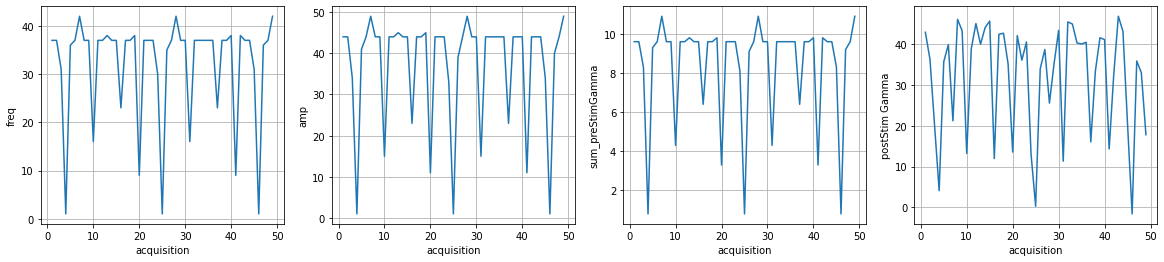

In [71]:
fig = plt.figure(figsize=(20,4));
plt.subplot(1,4,1)
plt.plot(np.arange(1,50), ucb_sample_dynamic[1:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.grid(visible=True)

plt.subplot(1,4,2)
plt.plot(np.arange(1,50), ucb_sample_dynamic[1:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.grid(visible=True)

plt.subplot(1,4,3)
plt.plot(np.arange(1,50), ucb_sample_dynamic[1:,2], label=r"sum_preStimGamma")
plt.xlabel("acquisition")
plt.ylabel("sum_preStimGamma")
plt.grid(visible=True)

plt.subplot(1,4,4)
plt.plot(np.arange(1,50), postStimGamma_predicted_from_firstModel_dynamic[1:,], label=r"postStimGamma")
plt.xlabel("acquisition")
plt.ylabel("postStim Gamma")
plt.grid(visible=True)
plt.show()

 C:\Users\sinad\anaconda3\envs\GP_env\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x2a2629b1310>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2a259c83280>]}

(1, 0)
(1, 10)
(1, 50)


{'dataplot': [<matplotlib.collections.PathCollection at 0x2a2626cfaf0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x2a2623a19d0>]}

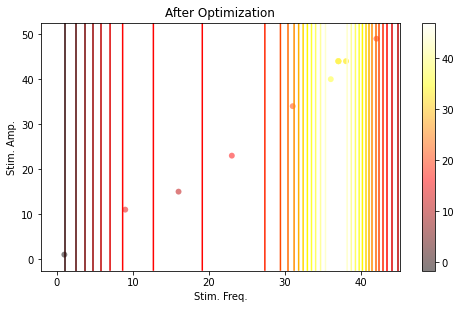

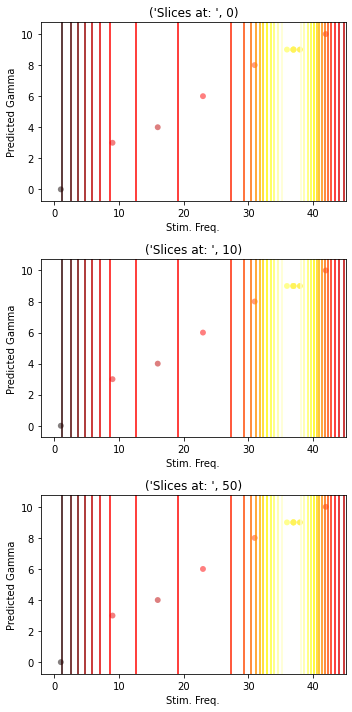

In [72]:
figure = GPy.plotting.plotting_library().figure(2, 1, figsize=(7,8))
canvas = trained_model_BaO_Dynamic.plot(figure=figure, visible_dims=[0,1],row=(2), legend=False, xlabel='Stim. Freq.' , ylabel='Stim. Amp.', 
                        title='After Optimization');
display(canvas)
ax = plt.gca()
PCM = ax.get_children()[0]
plt.colorbar(PCM, ax=ax)

# Plotting slices of the model at amplitudes of 0, 10, and 50
slices = [0, 10, 50]
figure = GPy.plotting.plotting_library().figure(3, 1, figsize=(5,10))

for i, y in zip(range(3), slices):
    print((1,y));

    canvas = trained_model_BaO_Dynamic.plot(figure=figure, fixed_inputs=[(slice_dim, y)], row=(i+1), plot_data=True, legend=False,
                    xlabel='Stim. Freq.', ylabel=ylabel, title=("Slices at: ", y));

display(canvas);

### 1.5: comparing static and dynamic BaO

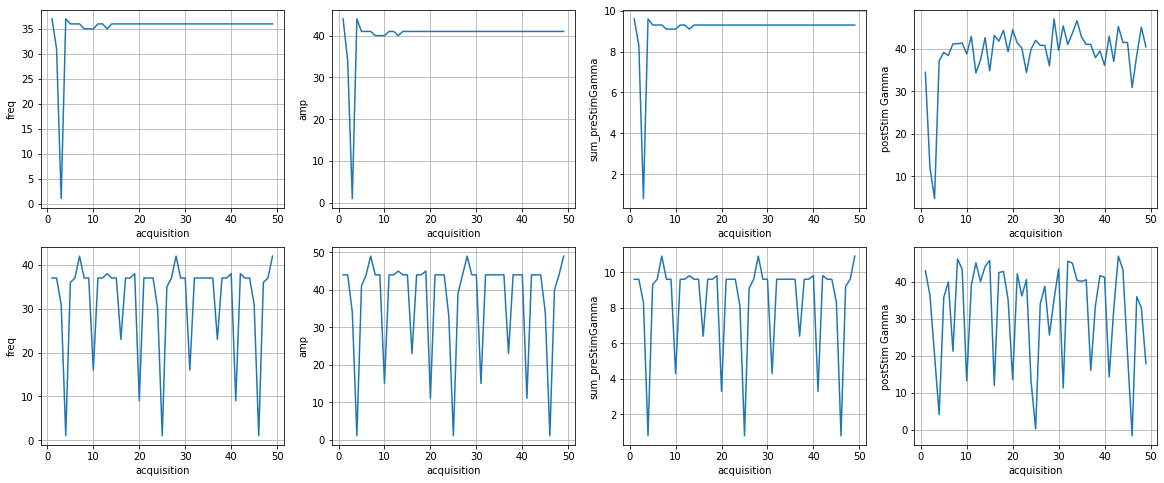

In [73]:
fig = plt.figure(figsize=(20,8));
fig.title = "Static vs. Dynamic BaO"
plt.subplot(2,4,1)
plt.plot(np.arange(1,50), ucb_sample[1:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.grid(visible=True)

plt.subplot(2,4,2)
plt.plot(np.arange(1,50), ucb_sample[1:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.grid(visible=True)

plt.subplot(2,4,3)
plt.plot(np.arange(1,50), ucb_sample[1:,2], label=r"sum_preStimGamma")
plt.xlabel("acquisition")
plt.ylabel("sum_preStimGamma")
plt.grid(visible=True)

plt.subplot(2,4,4)
plt.plot(np.arange(1,50), postStimGamma_predicted_from_firstModel[1:,], label=r"postStimGamma")
plt.xlabel("acquisition")
plt.ylabel("postStim Gamma")
plt.grid(visible=True)

plt.subplot(2,4,5)
plt.plot(np.arange(1,50), ucb_sample_dynamic[1:,0], label=r"frequency")
plt.xlabel("acquisition")
plt.ylabel("freq")
plt.grid(visible=True)

plt.subplot(2,4,6)
plt.plot(np.arange(1,50), ucb_sample_dynamic[1:,1], label=r"amplitude")
plt.xlabel("acquisition")
plt.ylabel("amp")
plt.grid(visible=True)

plt.subplot(2,4,7)
plt.plot(np.arange(1,50), ucb_sample_dynamic[1:,2], label=r"sum_preStimGamma")
plt.xlabel("acquisition")
plt.ylabel("sum_preStimGamma")
plt.grid(visible=True)

plt.subplot(2,4,8)
plt.plot(np.arange(1,50), postStimGamma_predicted_from_firstModel_dynamic[1:,], label=r"postStimGamma")
plt.xlabel("acquisition")
plt.ylabel("postStim Gamma")
plt.grid(visible=True)
plt.show()


x_BaO, y_BaO, trained_model_BaO = model.bayes_opt_update_state(trained_model_BaO, U1, X0_psd, X1, n_samples, n_burn_in, sample, acquisition_function, 
                                                               ker_BaO, slice_dim, ylabel, initialize_data_dr_sim)

# initialize_data_dr_sim(U1_combo, X0_psd_combo, X1_combo, ker_BaO, slice_dim, ylabel)

### Acquisition Function pseudo code and draft
function [X_samples, Y_samples, X_optimal_est, Y_optimal_est, Y_ground_truth] =  ...
    bayes_opt_on_state_dr_model(objective_model, input_space, n_samples, n_burn_in, acquisition_function, acq_params, measurement_function)


X_samples       = nan(n_samples, size(input_space,2));
X_optimal_est   = nan(n_samples, size(input_space,2));

Y_samples       = nan(n_samples, 1);
Y_optimal_est   = nan(n_samples, 1);
Y_ground_truth  = nan(n_samples, 1);

objective_est   = gp_object(); % GP model used in BaO 
burn_in_idx     = randi(size(input_space,1), n_burn_in,1);

objective_model.set_initial_state(); % Ground Truth simulation model 

for c1 = 1:n_samples
    
    if c1 <= n_burn_in
        X_samples(c1,:)     = input_space(burn_in_idx(c1),:);
    else
        X_samples(c1,:)     = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, c1);
    end
    
    Y_samples(c1,1)         = objective_model.sample(X_samples(c1,:));
    
    if c1 > 1    
        objective_est.initialize_data(X_samples(1:c1,:), Y_samples(1:c1)) % Exclude NaN when initializing GP

        [X_optimal_est(c1,:), Y_optimal_est(c1,:)] ...
            = objective_est.discrete_extrema(input_space);

        Y_ground_truth(c1)  = objective_model.predict_state(X_optimal_est(c1,:));
    end
    objective_model.transition_state();
end

end


#### Next make the bayes_opt_update_state_dr()
function X_new_sample = bayes_opt_update_state_dr(objective_est, input_space, acquisition_function, acq_params, t)

[Y_mean, ~, ~, Y_uncertainty] = objective_est.predict(input_space);

switch acquisition_function
    case 'PI'
        acq_value = predicted_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'EI'
        acq_value = expected_improvement(Y_mean, Y_uncertainty, acq_params); % TODO
    case 'UCB'
        acq_value = upper_confidence_bound(Y_mean, Y_uncertainty, acq_params, t);
end

[~, max_idx] = max(acq_value);

X_new_sample = input_space(max_idx,:);

end